In [2]:
from __future__ import annotations
import enum
import os
import pathlib
import typing
from collections import defaultdict
from types import MappingProxyType

import albumentations as alb
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import torch
import torch.utils.data
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# model import
import segmentation_models_pytorch as smp

DATAPATH = pathlib.Path(os.getenv('BOOPMYNOSE_DATASET', '/var/boopmynose'))

**prepare dataset**

In [18]:
_Annotations: typing.TypeAlias = typing.Mapping[str, typing.Sequence[pathlib.Path]]
_Images: typing.TypeAlias = typing.Sequence[pathlib.Path]
# _AugmentFunc: typing.TypeAlias = typing.Callable[[torch.Tensor, torch.Tensor], tuple[torch.Tensor, torch.Tensor]]

class _AugmentFunc(typing.Protocol):
    def __call__(self, **kwargs: np.ndarray) -> typing.Mapping[str, np.ndarray]: ...


class _SplitSpec(typing.TypedDict):
    test_size: typing.NotRequired[float | None]
    train_size: typing.NotRequired[float | None]
    random_state: typing.NotRequired[int | np.random.RandomState | None]
    shuffle: typing.NotRequired[bool]
    stratify: typing.NotRequired[npt.ArrayLike | None]


class Label(enum.IntFlag):
    CAT = enum.auto()
    DOG = enum.auto()
    WILD = enum.auto()
    ALL = CAT | DOG | WILD

class Tag(enum.IntFlag):
    EYE = enum.auto()
    NOSE = enum.auto()
    ALL = EYE | NOSE


class Dataset(torch.utils.data.Dataset):
    """ AFPHQ dataset """

    @typing.overload
    def __init__(self,
                 __labels: Label = Label.ALL,
                 __tags: Tag = Tag.ALL,
                 *,
                 dtype: torch.dtype = torch.int32,
                 augment: _AugmentFunc | None = None,
                 ): ...
    @typing.overload
    def __init__(self,
                 __annotations: _Annotations,
                 __images: _Images,
                 __tags: Tag = Tag.ALL,
                 *,
                 dtype: torch.dtype = torch.int32,
                 augment: _AugmentFunc | None = None,
                 ): ...
    def __init__(self,
                 *args,
                 dtype: torch.dtype = torch.int32,
                 augment: _AugmentFunc | None = None,
                 ):
        self.dtype = dtype
        self.augment = augment
        # build files list
        self.path = pathlib.Path(DATAPATH)
        self.annotations: _Annotations
        self.images: _Images
        # extend dataset init parameters
        match args:
            case (Label(),):
                args = (*args, Tag.ALL)
            case (Tag(),):
                args = (Label.ALL, *args)
            case ():
                args = (Label.ALL, Tag.ALL)
        # collect metadata
        match args:
            # whole dataset
            case (Label() as labels, Tag() as tags):
                self.tags = tags
                _annotations, _images = defaultdict(list), set()
                for label in labels:
                    _label = (label._name_ or "").lower()
                    for file in self.path.joinpath(f'mask/{_label}').glob('*.npy'):
                        name, suffix, tag, *_ = file.name.split('.')
                        if Tag[tag.upper()] not in tags:
                            continue
                        image = self.path.joinpath(_label, name).with_suffix(f'.{suffix}')
                        if not image.exists():
                            continue
                        _images.add(image)
                        _annotations[name].append(file)
                    # recast to immutable
                    self.annotations = MappingProxyType({
                        k: tuple(v) for k, v in _annotations.items()
                    })
                    self.images = tuple(sorted(_images))
            # train/valid split
            case _:
                self.annotations = MappingProxyType({k: tuple(v) for k, v in args[0].items()})
                self.images = tuple(args[1])
                self.tags = args[2]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index) -> tuple[torch.Tensor, Label, torch.Tensor]:
        itempath = self.images[index].absolute()
        # load image
        image = np.array(Image.open(itempath.as_posix()))
        # load tags mask
        _mask = defaultdict(lambda: np.zeros(image.shape[:2]))
        for file in self.annotations[self.images[index].stem]:
            tag = Tag[file.name.split('.')[2].upper()]
            _mask[tag] += np.load(file)
        mask = np.stack([_mask[tag].clip(0, 1) for tag in Tag])
        # apply augmentations
        if isinstance(self.augment, typing.Callable):
            sample = self.augment(image=image, mask=mask.transpose(1, 2, 0))
            image, mask = sample['image'], sample['mask'].transpose(2, 0, 1)
        # cast to Tensor
        return (
            torch.as_tensor(image, dtype=self.dtype).permute(2, 0, 1),
            Label[itempath.parent.name.upper()],
            torch.as_tensor(mask, dtype=self.dtype)
        )

    def show_item(self,
                  index: int | None = None,
                  predicted: torch.Tensor | None = None,
                  **kwargs):
        if index is None:
            index = np.random.default_rng().integers(len(self.images))
        image, part, mask = self[index]
        fig, ax = plt.subplots(1, 2 + (predicted is not None), **kwargs)
        fig.suptitle(f'dataset item #{index}; {self.images[index].stem}')
        # draw original image
        ax[0].set_title(f'image [label={part}]')
        ax[0].imshow(image.permute(1, 2, 0) / image.max())
        # draw original mask
        mask = mask.permute([1, 2, 0]).numpy() * range(1, len(self.tags) + 1)
        ax[1].set_title('original mask')
        ax[1].imshow(mask.sum(axis=2))
        # draw predicted mask
        if predicted is not None:
            mask = predicted.permute([1, 2, 0]).numpy() * range(1, len(self.tags) + 1)
            ax[2].set_title('predicted mask')
            ax[2].imshow(mask.sum(axis=2))
        plt.show()

    def split(self, **kwargs: typing.Unpack[_SplitSpec]) -> tuple[Dataset, Dataset]:
        """ Train/Valid split """
        train_images, valid_images = train_test_split(self.images, **kwargs)
        train_annotations = {k.stem: self.annotations[k.stem] for k in train_images}
        valid_annotations = {k.stem: self.annotations[k.stem] for k in valid_images}
        return (
            Dataset(train_annotations, train_images, self.tags, dtype=self.dtype, augment=self.augment),
            Dataset(valid_annotations, valid_images, self.tags, dtype=self.dtype, augment=self.augment),
        )


1100


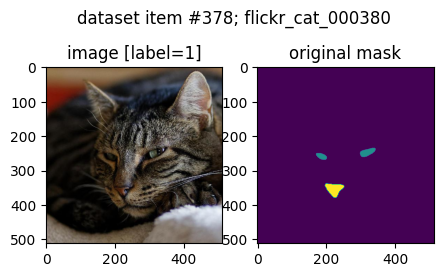

In [12]:
dataset = Dataset()
print(len(dataset))
dataset.show_item(figsize=(5, 3))

**describe model**

In [11]:
_Loss: typing.TypeAlias = torch.nn.Module


class Trainable(torch.nn.Module):
    def __init__(self,
                 model: ...,    # TODO hint
                 preprocessor: ...,
                 ):
        super().__init__()
        self._model = model
        self._preprocessor = preprocessor
        self.device: torch.device = torch.device('cpu')

    def forward(self, x: torch.Tensor):
        inputs = self._preprocessor(x) if self._preprocessor else x
        return self._model(inputs.to(self.device))

    @typing.override
    def to(self, *args, **kwargs) -> typing.Self:
        device, *_ = torch._C._nn._parse_to(*args, **kwargs)
        if device:
            self.device = device
        return super().to(*args, **kwargs)

    def fit(self,
            loader: torch.utils.data.DataLoader,
            optim: torch.optim.optimizer.Optimizer,
            crit: _Loss,
            *,
            epochs: int = 5,
            valid_loader: ... = None,
            valid_on_train: bool = True,
            ):
        self.crit = crit
        self.train()
        # epochs
        for ep in range(epochs):
            sum_loss, items = 0.0, 0
            pbar = tqdm(enumerate(loader), total=len(loader), desc=f'Epoch {ep + 1}/{epochs}')
            for i, batch in pbar:
                # get batch
                inputs, mask = batch[0], batch[2].to(self.device)
                optim.zero_grad()
                outputs = self(inputs)
                loss = crit(outputs, mask)
                loss.backward()
                optim.step()
                # calculate loss
                sum_loss += loss.item()
                items += len(mask)
                pbar.set_postfix({'cumulative loss per item': sum_loss / items})
                # evaluate
                if (i + 1 == len(loader)):
                    pbar.set_postfix_str('calculating final loss...')
                    self.train_loss, self.train_metric, self.valid_loss, self.valid_metric = 0, 0, 0, 0
                    # on train evaluation
                    if valid_on_train:
                        _, self.train_loss, self.train_metric = self.predict_(loader)
                    # on train validation
                    if valid_loader is not None:
                        _, self.valid_loss, self.valid_metric = self.predict_(valid_loader)
                    # collect evaluation report
                    report = {'loss': f'{self.train_loss:.3f}/{self.valid_loss:.3f}',
                              'metric': f'{self.train_metric:.3f}/{self.valid_metric:.3f}'}
                    pbar.set_postfix(report)
                    self.train()
        if self.device.type == 'cuda':
            torch.cuda.empty_cache()
        print('\nDone.')

    def predict_(self, loader, verbose=False):
        self.eval()
        outputs, loss = None, 0
        TP, FP, FN, TN = torch.LongTensor(), torch.LongTensor(), torch.LongTensor(), torch.LongTensor()
        iterator = tqdm(loader, total=len(loader), desc='Predicting') if verbose else loader
        for batch in iterator:
            inputs, mask = batch[0], batch[2].to(self.device)
            outputs = self(inputs)
            loss += self.crit(outputs, mask).item() / len(loader)
            # back recast
            outputs = outputs.detach().cpu()
            mask = mask.reshape(outputs.shape).int().detach().cpu()
            tp, fp, fn, tn = smp.metrics.get_stats(outputs, mask, mode='binary', threshold=0.5)
            torch.cat([TP.clone(), tp], out=TP.resize_(0))
            torch.cat([FP.clone(), fp], out=FP.resize_(0))
            torch.cat([FN.clone(), fn], out=FN.resize_(0))
            torch.cat([TN.clone(), tn], out=TN.resize_(0))
        metric = smp.metrics.iou_score(TP, FP, FN, TN, reduction='micro')
        if verbose:
            print(f'loss: {loss:.3f}', f'metric: {metric:.3f}', sep='\n')
        return outputs, loss, metric

**augmentations**

In [260]:
augment = alb.Compose([
    alb.ColorJitter(brightness=(0.75, 1.1),
                    contrast=(0.75, 1.1),
                    saturation=(0.75, 1.1),
                    hue=(-0.3, 0.3),
                    p=0.5
                    ),
    # alb.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2),
    #                              contrast_limit=(-0.2, 0.2),
    #                              p=0.5),
    alb.Rotate(limit=(-90, 90), p=0.75),
    alb.VerticalFlip(p=0.75),
])

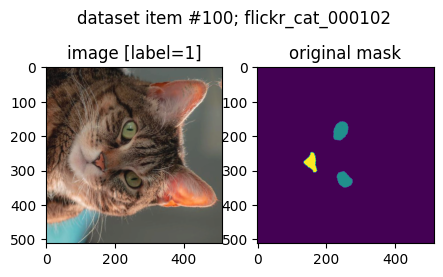

In [262]:
dataset = Dataset(augment=augment)
dataset.show_item(100, figsize=(5, 3))

**prepare & fit**

In [263]:
# init device
device: typing.Literal['cpu', 'cuda'] = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

# this for multiple notebook re-run
if device.startswith('cuda'):
    torch.cuda.empty_cache()
print(device)

cuda


In [264]:
BATCH_SIZE = 4

dataset = Dataset(Label.CAT, dtype=torch.float32)
train_dataset, valid_dataset = dataset.split(test_size=0.2, random_state=11)
# prepare loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [265]:
torch.manual_seed(11)
# pretrained = smp.Linknet(encoder_name='resnet34', encoder_depth=5, classes=1, activation='sigmoid')
# pretrained = smp.Unet(encoder_name='resnet34', encoder_depth=4, decoder_channels=(256, 128, 64, 32), classes=2, activation='sigmoid')
pretrained = smp.Unet(encoder_name='resnet34', encoder_depth=5, classes=2, activation='sigmoid')
net = Trainable(pretrained, None).to(device)

optimizer = torch.optim.Adam(net._model.parameters(), lr=0.001)
# criterion = smp.losses.DiceLoss('binary')
criterion = torch.nn.BCELoss()
# criterion = smp.losses.SoftBCEWithLogitsLoss()

net.fit(train_loader, optimizer, criterion, epochs=10, valid_loader=valid_loader)

Epoch 10/10: 100%|██████████| 220/220 [01:27<00:00,  2.52it/s, loss=0.002/0.003, metric=0.930/0.907]


Done.


**result overview**

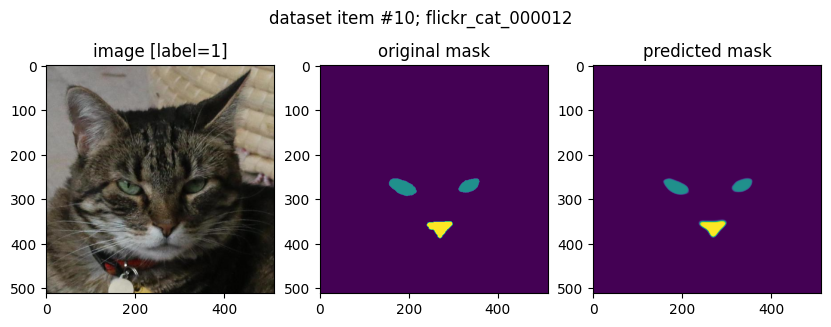

In [266]:
idx = 10
image, label, mask = dataset[idx]

net.eval()
predicts = net(image.reshape(1, *image.shape).to(device))
mask = predicts.reshape(mask.shape).detach().cpu()
# dataset.show_item(idx, mask, figsize=(10, 3.5))
dataset.show_item(idx, mask, figsize=(10, 3.5))

**check unseen image**

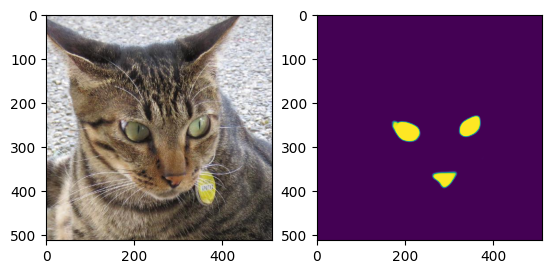

In [269]:
path = DATAPATH.joinpath('cat/pixabay_cat_002185.jpg')
image = torch.as_tensor(np.array(Image.open(path)), dtype=torch.float32)

pred = net(image.permute(2, 0, 1).reshape(1, *image.shape[::-1]).to(device))
pred = pred.reshape(mask.shape).detach().cpu()

fig, ax = plt.subplots(1, 2)

ax[0].imshow(image.int())
ax[1].imshow(pred.sum(axis=0))
# ax[1].imshow(pred[1] > 0.5)

plt.show()

**export model**

In [271]:
path = DATAPATH.joinpath('cat/flickr_cat_000007.jpg')
image = torch.as_tensor(np.array(Image.open(path)), dtype=torch.float32).permute(2, 0, 1)


expnet = net.to('cpu')
expnet.eval()
# declare inputs/outputs
x = torch.randn(1, *image.shape)
torch_out = expnet(x)
# export
torch.onnx.export(
    expnet,
    x,
    'api/boopmynose.onnx.model',
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0 : 'batch_size'},
        'output': {0 : 'batch_size'}
    },
    # opset_version=10
)

In [302]:
# import onnxruntime

# model = onnxruntime.InferenceSession("api/boopmynose.onnx.model", providers=["CPUExecutionProvider"])

# ort_inputs = {model.get_inputs()[0].name: image.numpy().reshape([1, *image.shape])}
# ort_outs = model.run(None, ort_inputs)
# # np.testing.assert_allclose(torch_out.detach().numpy(), ort_outs[0], rtol=1e-01, atol=1e-07)
# np.testing.assert_allclose(ort_outs[0], torch_out.detach().numpy(), rtol=1e-7, atol=-1)

In [ ]:
#